In [0]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

## Load data

In [0]:
TRAINING_DATA_URL = 'https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv'
TRAINING_LABELS_URL = 'https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv'
x_train = pd.read_csv(TRAINING_DATA_URL, index_col='id')
y_train = pd.read_csv(TRAINING_LABELS_URL, index_col='id')
df_train = x_train.merge(y_train, on='id')
df_train.shape

(59400, 40)

## Remove single observation from 2002

In [0]:
df_train = df_train.drop(14428, errors='ignore')
df_train.shape

(59399, 40)

## Fill missing data

In [0]:
def fill_missing_geo(row):
  if(row.longitude == 0):
    result = df_train[(df_train['region']==row.region) & (df_train['longitude']!=0)].longitude.mean()
    row.longitude= result
  
  if(row.latitude == -2e-8):
    result = df_train[(df_train['region']==row.region) & (df_train['latitude']!=-2e-8)].latitude.mean()
    row.latitude= result
  
  return row

In [0]:
df_train = df_train.apply(lambda x: fill_missing_geo(x), axis=1)

## Observation date - new features

In [0]:
df_train['month_recorded'] = df_train['date_recorded'].map(lambda x: x.split('-')[1])
df_train['day_recorded'] = df_train['date_recorded'].map(lambda x: x.split('-')[2])

## Fill NA values
Can be improved only if feature has high importance!

In [0]:
df_train.permit = df_train.permit.fillna(False)
df_train.scheme_management = df_train.scheme_management.fillna('Other')

## Boolean columns to int 0/1

In [0]:
df_train['public_meeting'] = df_train['public_meeting'].apply(lambda x : 1 if x==True else 0)
df_train['permit'] = df_train['permit'].apply(lambda x : 1 if x==True else 0)

## Others - to be redone
- feature selection
- feature scaling
- feature transformation (encoding, labelling etc.)

In [0]:
CONTINOUS_VALUE_COLUMNS = ['longitude', 'latitude','month_recorded','day_recorded']
DATE_COLUMNS = []
ORDINAL_VALUE_COLUMNS = []
NOMINAL_VALUE_COLUMNS = [ 'basin','region', 'district_code','scheme_management', #'installer',
                         'extraction_type_class', 'payment',  'quantity','source_class', 'waterpoint_type']
BOOLEAN_VALUE_COLUMNS = ['permit', 'public_meeting']
TARGET_COLUMN = 'status_group'

len(CONTINOUS_VALUE_COLUMNS)+len(DATE_COLUMNS)+len(ORDINAL_VALUE_COLUMNS)+len(NOMINAL_VALUE_COLUMNS)+len(BOOLEAN_VALUE_COLUMNS)

15

In [0]:
filtered_df_train = df_train[CONTINOUS_VALUE_COLUMNS + DATE_COLUMNS + ORDINAL_VALUE_COLUMNS + NOMINAL_VALUE_COLUMNS+BOOLEAN_VALUE_COLUMNS+[TARGET_COLUMN]]
filtered_df_train.head()

,longitude,latitude,month_recorded,day_recorded,basin,region,district_code,scheme_management,extraction_type_class,payment,quantity,source_class,waterpoint_type,permit,public_meeting,status_group
id,,,,,,,,,,,,,,,,
69572,34.938093,-9.856322,03,14,Lake Nyasa,Iringa,5,VWC,gravity,pay annually,enough,groundwater,communal standpipe,0,1,functional
8776,34.698766,-2.147466,03,06,Lake Victoria,Mara,2,Other,gravity,never pay,insufficient,surface,communal standpipe,1,0,functional
34310,37.460664,-3.821329,02,25,Pangani,Manyara,4,VWC,gravity,pay per bucket,enough,surface,communal standpipe multiple,1,1,functional
67743,38.486161,-11.155298,01,28,Ruvuma / Southern Coast,Mtwara,63,VWC,submersible,never pay,dry,groundwater,communal standpipe multiple,1,1,non functional
19728,31.130847,-1.825359,07,13,Lake Victoria,Kagera,1,Other,gravity,never pay,seasonal,surface,communal standpipe,1,1,functional


In [0]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
result = encoder.fit_transform(filtered_df_train[NOMINAL_VALUE_COLUMNS])
encoder.get_feature_names()

array(['x0_Internal', 'x0_Lake Nyasa', 'x0_Lake Rukwa',
       'x0_Lake Tanganyika', 'x0_Lake Victoria', 'x0_Pangani',
       'x0_Rufiji', 'x0_Ruvuma / Southern Coast', 'x0_Wami / Ruvu',
       'x1_Arusha', 'x1_Dar es Salaam', 'x1_Dodoma', 'x1_Iringa',
       'x1_Kagera', 'x1_Kigoma', 'x1_Kilimanjaro', 'x1_Lindi',
       'x1_Manyara', 'x1_Mara', 'x1_Mbeya', 'x1_Morogoro', 'x1_Mtwara',
       'x1_Mwanza', 'x1_Pwani', 'x1_Rukwa', 'x1_Ruvuma', 'x1_Shinyanga',
       'x1_Singida', 'x1_Tabora', 'x1_Tanga', 'x2_0', 'x2_1', 'x2_2',
       'x2_3', 'x2_4', 'x2_5', 'x2_6', 'x2_7', 'x2_8', 'x2_13', 'x2_23',
       'x2_30', 'x2_33', 'x2_43', 'x2_53', 'x2_60', 'x2_62', 'x2_63',
       'x2_67', 'x2_80', 'x3_Company', 'x3_None', 'x3_Other',
       'x3_Parastatal', 'x3_Private operator', 'x3_SWC', 'x3_Trust',
       'x3_VWC', 'x3_WUA', 'x3_WUG', 'x3_Water Board',
       'x3_Water authority', 'x4_gravity', 'x4_handpump', 'x4_motorpump',
       'x4_other', 'x4_rope pump', 'x4_submersible', 'x4_wind-powe

In [0]:
from sklearn.preprocessing import OrdinalEncoder
target_enc = OrdinalEncoder()
target_result = target_enc.fit_transform(filtered_df_train[TARGET_COLUMN].values.reshape(-1,1))
target_enc.categories_

[array(['functional', 'functional needs repair', 'non functional'],
       dtype=object)]

In [0]:
from sklearn.preprocessing import PowerTransformer
p_trans = PowerTransformer()
continous_values_transformed = p_trans.fit_transform(filtered_df_train[CONTINOUS_VALUE_COLUMNS])

In [0]:
output_cols = CONTINOUS_VALUE_COLUMNS.copy()
output_cols.extend(BOOLEAN_VALUE_COLUMNS.copy())
output_cols.extend(encoder.get_feature_names())
output_cols.append('target')
output_data = np.copy(result)
output_data = np.concatenate((continous_values_transformed, filtered_df_train[BOOLEAN_VALUE_COLUMNS], result, target_result),axis =1)
output_cols
df_output = pd.DataFrame(output_data, columns=output_cols)
df_output.head()

,longitude,latitude,month_recorded,day_recorded,permit,public_meeting,x0_Internal,x0_Lake Nyasa,x0_Lake Rukwa,x0_Lake Tanganyika,x0_Lake Victoria,x0_Pangani,x0_Rufiji,x0_Ruvuma / Southern Coast,x0_Wami / Ruvu,x1_Arusha,x1_Dar es Salaam,x1_Dodoma,x1_Iringa,x1_Kagera,x1_Kigoma,x1_Kilimanjaro,x1_Lindi,x1_Manyara,x1_Mara,x1_Mbeya,x1_Morogoro,x1_Mtwara,x1_Mwanza,x1_Pwani,x1_Rukwa,x1_Ruvuma,x1_Shinyanga,x1_Singida,x1_Tabora,x1_Tanga,x2_0,x2_1,x2_2,x2_3,...,x3_Other,x3_Parastatal,x3_Private operator,x3_SWC,x3_Trust,x3_VWC,x3_WUA,x3_WUG,x3_Water Board,x3_Water authority,x4_gravity,x4_handpump,x4_motorpump,x4_other,x4_rope pump,x4_submersible,x4_wind-powered,x5_never pay,x5_other,x5_pay annually,x5_pay monthly,x5_pay per bucket,x5_pay when scheme fails,x5_unknown,x6_dry,x6_enough,x6_insufficient,x6_seasonal,x6_unknown,x7_groundwater,x7_surface,x7_unknown,x8_cattle trough,x8_communal standpipe,x8_communal standpipe multiple,x8_dam,x8_hand pump,x8_improved spring,x8_other,target
0,-0.072579,-1.333935,-0.203651,-0.113275,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.164850,1.467179,-0.203651,-1.095515,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.914459,0.624939,-0.800019,1.052948,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.323128,-1.649368,-1.737012,1.349163,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
4,-1.511151,1.662763,1.031072,-0.227724,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Oversample

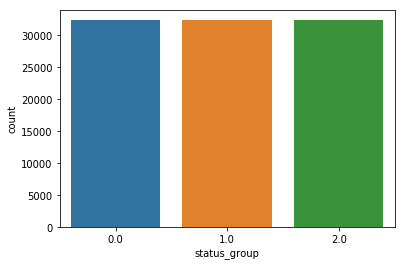

In [0]:
from imblearn.over_sampling import SMOTE
over_sampling = SMOTE(random_state=42, k_neighbors=5)
x_over_sampled, y_over_sampled = over_sampling.fit_resample(df_output.drop('target', axis=1), df_output.target)
sns.countplot(x='status_group', data=pd.DataFrame(y_over_sampled, columns=['status_group']));

In [0]:
df_oversampled = pd.DataFrame(np.column_stack((x_over_sampled, y_over_sampled)), columns=df_output.columns)

## NN

In [0]:
x = df_oversampled.drop('target', axis=1)
y = df_oversampled.target

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [0]:
import tensorflow.keras as keras
import tensorflow as tf

print('tensorflow', tf.__version__)
print('keras', keras.__version__)

tensorflow 1.14.0
keras 2.2.4-tf


In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(96774, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1000, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

NameError: ignored

In [0]:
model.fit(x_train.values, y_train.values, epochs=10)

Epoch 1/10
77419/77419 [==============================] - 74s 954us/sample - loss: 0.7179 - acc: 0.6816
Epoch 2/10
77419/77419 [==============================] - 73s 949us/sample - loss: 0.6153 - acc: 0.7300
Epoch 3/10
77419/77419 [==============================] - 74s 950us/sample - loss: 0.5737 - acc: 0.7507
Epoch 4/10
77419/77419 [==============================] - 74s 950us/sample - loss: 0.5469 - acc: 0.7616
Epoch 5/10
77419/77419 [==============================] - 74s 949us/sample - loss: 0.5258 - acc: 0.7736
Epoch 6/10
77419/77419 [==============================] - 74s 950us/sample - loss: 0.5098 - acc: 0.7792
Epoch 7/10
77419/77419 [==============================] - 74s 950us/sample - loss: 0.4966 - acc: 0.7851
Epoch 8/10
77419/77419 [==============================] - 74s 950us/sample - loss: 0.4839 - acc: 0.7906
Epoch 9/10
77419/77419 [==============================] - 73s 949us/sample - loss: 0.4745 - acc: 0.7952
Epoch 10/10
77419/77419 [==============================] - 74s 9

In [0]:
val_loss, val_acc = model.evaluate(x_test.values, y_test.values)
print(val_loss)
print(val_acc)

19355/19355 [==============================] - 4s 196us/sample - loss: 0.5256 - acc: 0.7808
0.5255984838173329
0.7808318
